In [1]:
import datetime
import os
import matplotlib
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from notebook_shared import utils

from statsmodels.tsa.seasonal import seasonal_decompose
from pandas import Series

import seaborn as sns
sns.set()
matplotlib.style.use('seaborn-colorblind')

INPUT_FILE = "dataset"
FSIZE = "tiny"

df = pd.read_parquet(utils.get_dataset_path(INPUT_FILE, FSIZE))

In [12]:
# Common Stuff
provider_region_mapping = {}
provider_region_mg_df = df.groupby( ['provider', 'region'], observed=True)['measure group'].unique().reset_index()
provider_region_mg_df
for index, row in provider_region_mg_df.iterrows():
    for measure_group in row['measure group']:
        region = row['region']
        provider = row['provider']
        measure_group = row['measure group'][0]
        provider_region_mapping[f"({provider}, {region})"] = {'region': region, 'measure group': measure_group, 'provider': provider}
        provider_region_mapping[f"({provider}, {region}, {measure_group})"] = {'region': region, 'measure group': measure_group, 'provider': provider}

In [3]:
mgdf = df.groupby(['provider', 'region'], observed=True)['measure group'].unique().dropna().reset_index()

In [5]:
cov_df = df.groupby( ['measure group', 'provider', 'region'], observed=True)['runtime'].apply(utils.cov).reset_index(name='Runtime CV').set_index(['provider', 'region'])

AWS


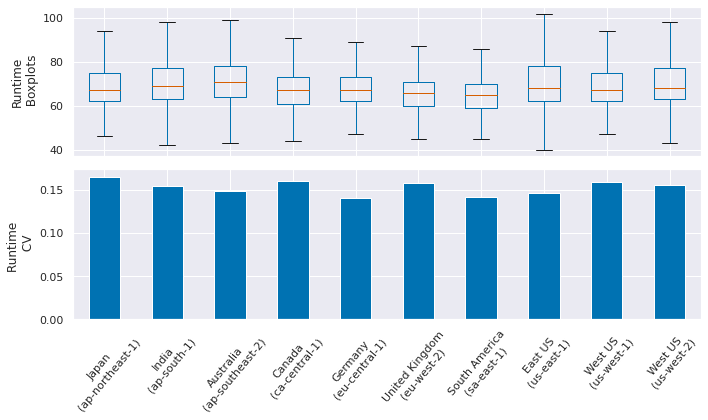

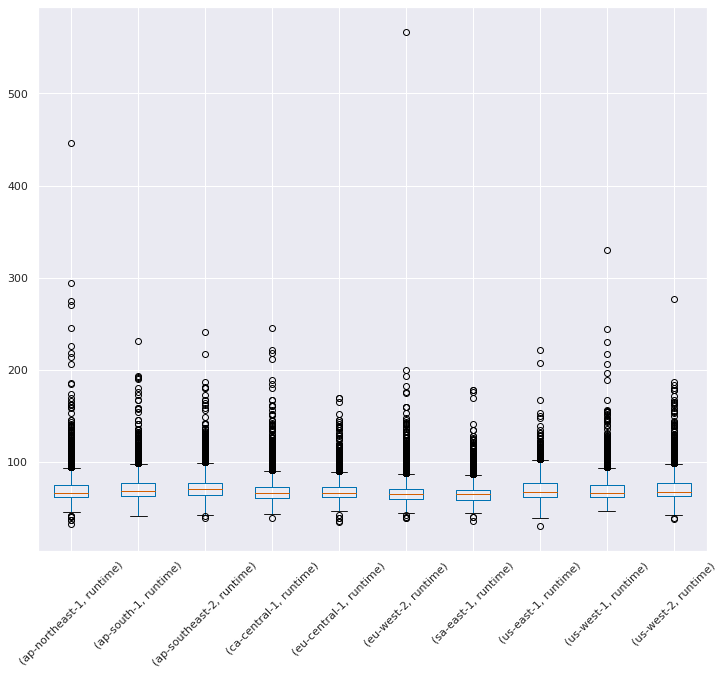

AZURE


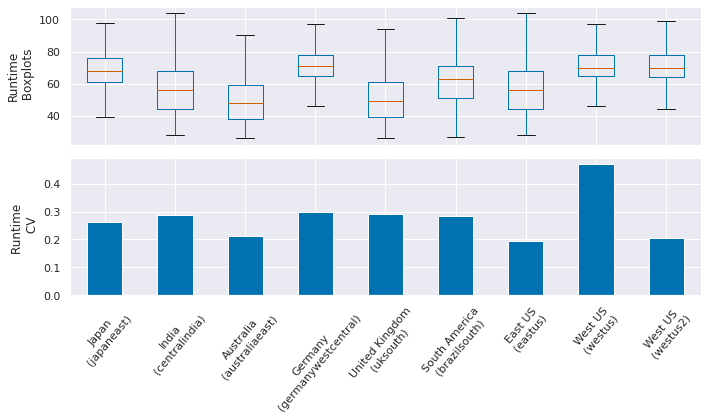

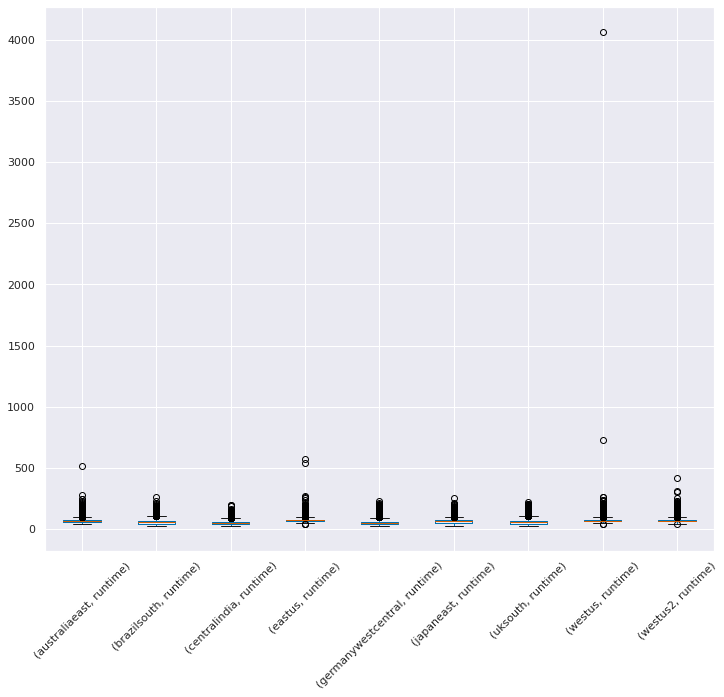

GCP


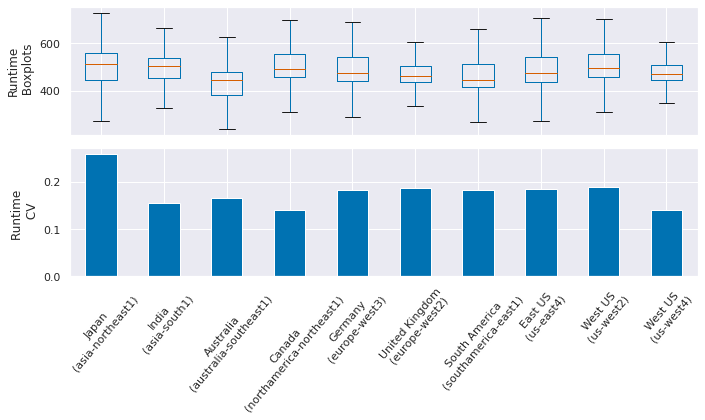

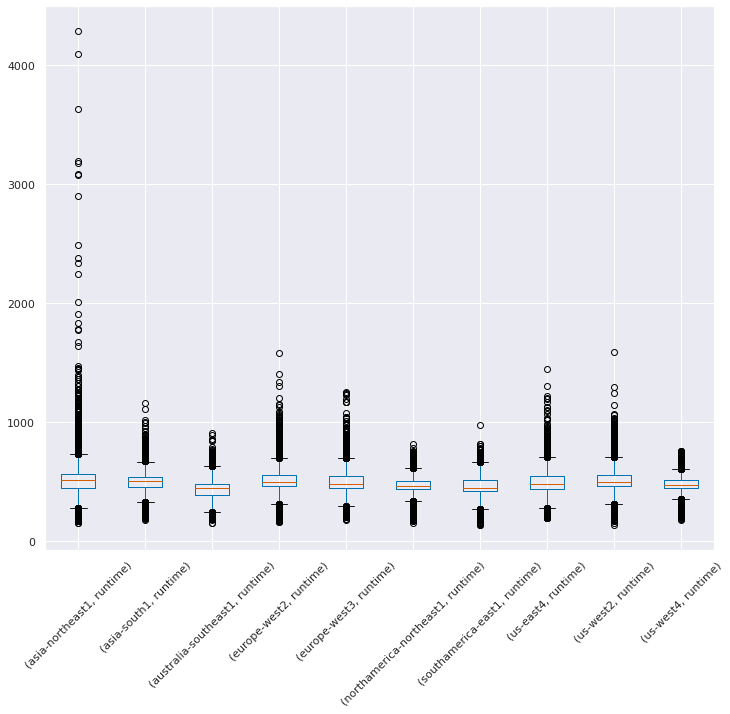

In [14]:
# mean_provider_region_df.sort_values(by=['measure_group', 'provider', 'region'])
cov_df.sort_values(by=['measure group', 'provider', 'region'])

for provider in cov_df.index.get_level_values('provider').unique():
    fig, axes = plt.subplots(figsize=(10,6), nrows=2, frameon=False)

    #mean_provider_region_df[cov_provider_region_df.index.isin([provider], level='provider')].plot(kind='bar', ax=axes[0])
    df[['provider', 'region', 'runtime']][df['provider'] == provider].groupby(['region'], observed=True).boxplot(subplots=False, ax=axes[0], showfliers=False)

    cov_df[cov_df.index.isin([provider], level='provider')].plot(kind='bar', ax=axes[1])

    axes[0].set_ylabel('Runtime\n Boxplots')
    # axes[0].get_legend().remove()
    labels = []
    for tick in axes[0].get_xticklabels():
        labels.append('')
    axes[0].set_xticklabels(labels)

    for tick in axes[1].get_xticklabels():
        tick.set_rotation(50)

    # Set Region Names
    labels = []
    for tick in axes[1].get_xticklabels():
        mapping = provider_region_mapping[tick.get_text()]
        region = mapping['region']
        measure_group = mapping['measure group']
        labels.append(f"{measure_group}\n({region})")

    axes[1].get_legend().remove()
    axes[1].set_ylabel('Runtime \n CV')
    axes[1].set_xticklabels(labels)
    axes[1].set_xlabel('')


    fig.tight_layout()

    print(provider)
    # plt.savefig(f'provider_region_mean_cov_{provider}.pdf')
    plt.show()
    plt.close()

    # Generate a control figure - because I cannot fore the matching
    fig, axes = plt.subplots(figsize=(12,10))
    df[['provider', 'region', 'runtime']][df['provider'] == provider].groupby(['region'], observed=True).boxplot(subplots=False, ax=axes, rot=45)
    # plt.savefig(f'provider_region_mean_cov_{provider}_box.pdf')
    plt.show()
    plt.close()